# Store Item Sales Prediction 

### Import packages

In [2]:
import os 

import math
import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

# from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import f_regression, mutual_info_regression


from sklearn.feature_extraction import DictVectorizer



from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [3]:
pd.set_option('display.precision', 3)

In [4]:
path = os.getcwd()
os.listdir(path)

['.ipynb_checkpoints',
 'Dockerfile',
 'dv.bin',
 'logs',
 'model.bin',
 'Pipfile',
 'Pipfile.lock',
 'predict.py',
 'README.md',
 'sales_analysis.html',
 'store_sales.ipynb',
 'submission.csv',
 'subs',
 'test.csv',
 'test_sample.json',
 'train.csv',
 'train.py',
 '__pycache__']

### Convert column names to lower case 
For the sake of convenience

In [5]:
def std_col_names(df):
    df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')
    return df

### Load data

In [6]:
df = std_col_names(pd.read_csv('train.csv'))


In [7]:
x_test = std_col_names(pd.read_csv('test.csv'))


### Observe data

In [8]:
df.head()

,item_id,item_w,item_type,item_mrp,outlet_id,outlet_year,outlet_size,outlet_location_type,sales
0,FDU32,21.027,Baking Goods,197.352,OUT046,2004,Small,Tier 2,2689.458
1,NCT54,21.102,Meat,148.250,OUT035,1987,Small,Tier 1,3437.350
2,FDW08,20.882,Hard Drinks,205.465,OUT035,1999,Small,Tier 3,3129.967
3,FDJ22,21.050,Starchy Foods,253.418,OUT046,1996,Small,Tier 1,1306.514
4,FDF47,21.248,Baking Goods,240.871,OUT035,1988,Small,Tier 3,1739.770


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87864 entries, 0 to 87863
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   item_id               87864 non-null  object 
 1   item_w                87864 non-null  float64
 2   item_type             87864 non-null  object 
 3   item_mrp              87864 non-null  float64
 4   outlet_id             87864 non-null  object 
 5   outlet_year           87864 non-null  int64  
 6   outlet_size           87864 non-null  object 
 7   outlet_location_type  87864 non-null  object 
 8   sales                 87864 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 6.0+ MB


In [10]:
df.describe()

,item_w,item_mrp,outlet_year,sales
count,87864.000,87864.000,87864.000,87864.000
mean,15.591,151.243,1999.871,1911.842
std,4.364,59.536,6.634,1291.386
min,7.993,32.910,1987.000,-1229.360
25%,10.969,112.423,1997.000,959.250
50%,15.831,145.581,1999.000,1606.308
75%,19.970,197.110,2004.000,2608.058
max,21.250,265.214,2009.000,10309.283


- Minimum sales value is -1230
- Check for number of items with negative sales values


In [11]:
a= (df['sales']<0).value_counts(normalize=True)
print(f'Ratio of negative sales values: {a.loc[1]:.3f}')

Ratio of negative sales values: 0.005


Ratio of negative sales values is negligible

array([[<AxesSubplot:title={'center':'item_w'}>,
        <AxesSubplot:title={'center':'item_mrp'}>],
       [<AxesSubplot:title={'center':'outlet_year'}>,
        <AxesSubplot:title={'center':'sales'}>]], dtype=object)

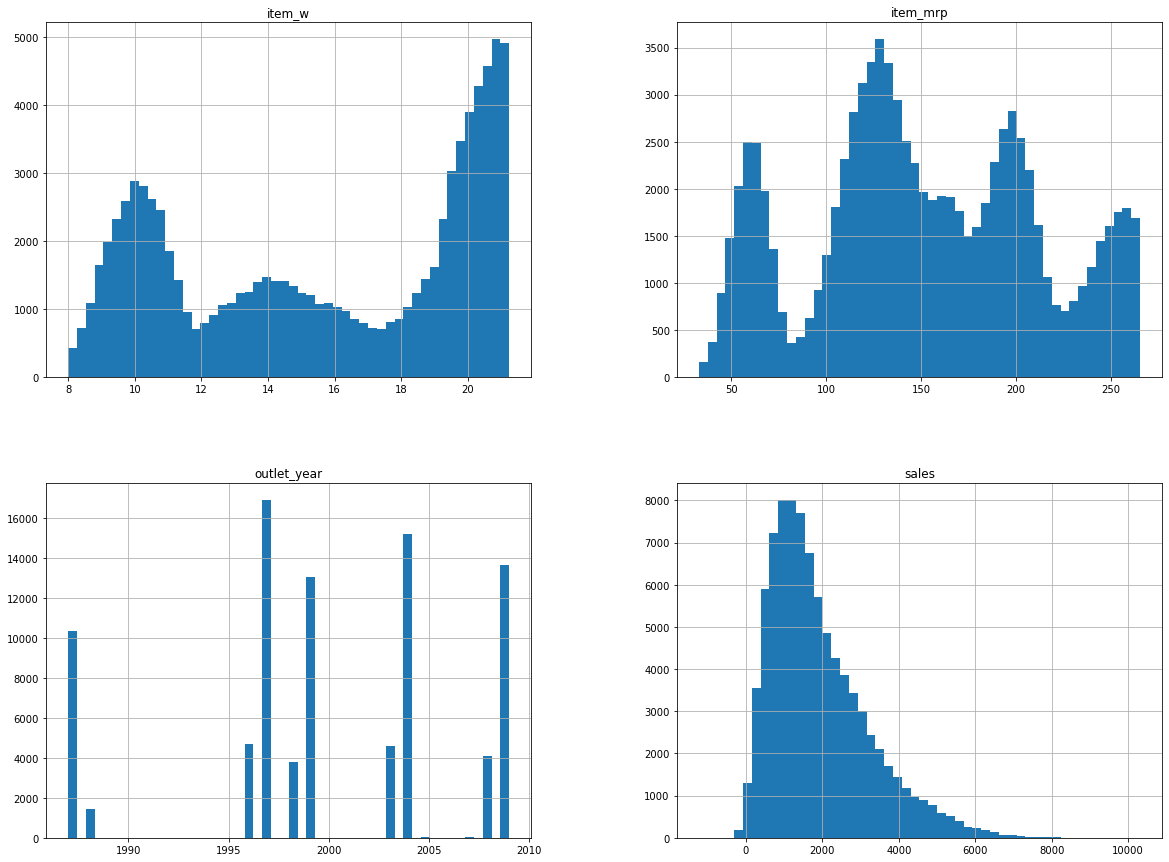

In [12]:
df.hist(bins= 50, figsize= (20,15))

Sales is right skewed distribution

In [13]:
# profile = ProfileReport(df)
# profile.to_file("sales_analysis.html")

### Split data

In [14]:
# Split data into train, validation
train, val = train_test_split(df, random_state=42, test_size=0.15)

In [15]:
# Reset index to be sequenced
train = train.reset_index(drop= True)
val=val.reset_index(drop= True)

#### Drop the target column from train and validation feature sets


In [16]:
x_train = train.drop('sales', axis= 1)
y_train = train['sales'].copy()

x_val = val.drop('sales', axis= 1)
y_val = val['sales'].copy()

In [17]:
len(df), len(x_train), len(x_val)

(87864, 74684, 13180)

### Extract numerical | categorical columns

In [18]:
num_cols = x_train.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_cols = x_train.select_dtypes(include=['object']).columns.to_list()

### Check the sales of items as a function of outlet attributes (Size | Location type)

In [19]:
outlet_df = (train.pivot_table( values = ['sales'], columns= ['outlet_location_type',\
                                                             'outlet_size'],\
                              aggfunc= 'sum')/math.pow(10, 6)).T.reset_index()
outlet_df

,outlet_location_type,outlet_size,sales
0,Tier 1,High,6.500
1,Tier 1,Medium,8.360
2,Tier 1,Small,40.644
3,Tier 2,High,5.461
4,Tier 2,Medium,5.614
5,Tier 2,Small,31.998
6,Tier 3,High,9.746
7,Tier 3,Medium,26.087
8,Tier 3,Small,8.311


<AxesSubplot:title={'center':'Sales vs Location type | size'}, xlabel='outlet_location_type', ylabel='Sales'>

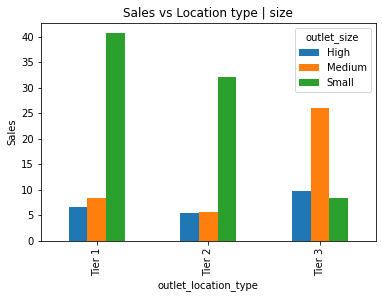

In [20]:
outlet_df.pivot("outlet_location_type", "outlet_size", "sales").plot(kind='bar', ylabel= 'Sales', title= 'Sales vs Location type | size')

<AxesSubplot:title={'center':'Sales by location type'}, xlabel='outlet_location_type', ylabel='Sales(M)'>

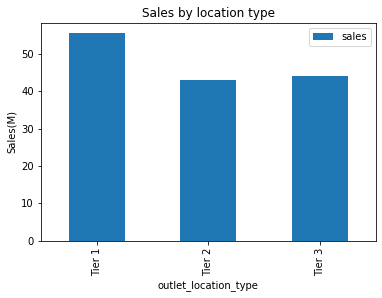

In [21]:
sales_by_location = outlet_df.groupby(by='outlet_location_type').agg('sum')
sales_by_location.plot(kind= 'bar', title= 'Sales by location type', ylabel='Sales(M)')

<AxesSubplot:title={'center':'Store count by location type'}>

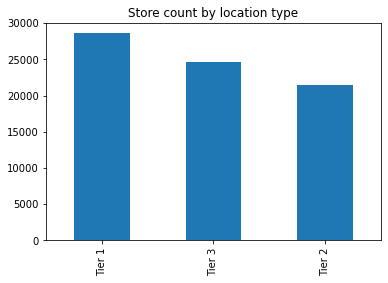

In [22]:
location_count = train['outlet_location_type'].value_counts()
location_count.plot(kind= 'bar', title= 'Store count by location type')


<AxesSubplot:xlabel='outlet_size', ylabel='Sales(M)'>

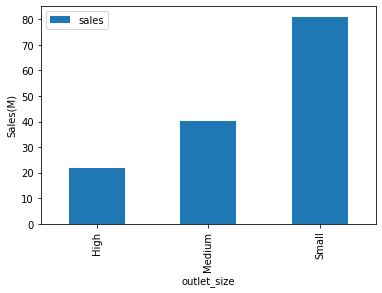

In [23]:
sales_by_size = outlet_df.groupby(by='outlet_size').agg('sum')
sales_by_size.plot(kind='bar', ylabel= 'Sales(M)')

Tier 1    28592
Tier 3    24605
Tier 2    21487
Name: outlet_location_type, dtype: int64

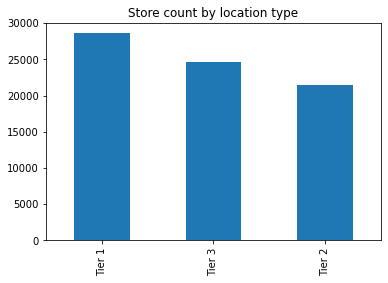

In [24]:
location_count = train['outlet_location_type'].value_counts()
location_count.plot(kind= 'bar', title= 'Store count by location type')
location_count

<AxesSubplot:title={'center':'Store count by size'}>

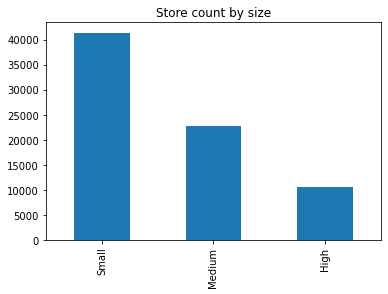

In [25]:
size_count = train['outlet_size'].value_counts()
size_count.plot(kind= 'bar', title= 'Store count by size')

### Insights on Sales vs Outlet
From the above pivot graphs, we get the following insights:

- The small stores in Tier 1 and Tier 2 locations account for exceptionally higher sales
- Small stores in aggregation account for highest sales
- Aggregated sales are in order (Tier 1->3->2)

## Helper Functions

In [26]:
def eval_rmse(model, train, val, train_actual= y_train, val_actual= y_val ):
    train_pred = model.predict(train)
    train_rmse = mean_squared_error(train_actual, train_pred, squared= False)
#     yield(f'{model} Train RMSE: {train_rmse}')

    val_pred = model.predict(val)
    val_rmse = mean_squared_error(val_actual,val_pred, squared= False)
#     yield(f'{model} Validation RMSE: {val_rmse}')
    
    return {f'{model}':(train_rmse, val_rmse)}

In [27]:
def retrieve_item_cats(df, col):
    item_cats={}
    for x in range(4):
        if x<3:
            item_cats[f'item_cat_{x}'] = [df[col][idx][x] for idx in range(len(df))]
        else:
            item_cats[f'item_cat_{x}'] = [df[col][idx][x:] for idx in range(len(df))]
    return item_cats
            
            

In [28]:
def process_data(df, cols):
    df_ids =  pd.DataFrame(retrieve_item_cats(df, 'item_id'))
    df_id_split = pd.concat([df, df_ids], axis= 1)
    df_id_split['out_size'] = df['outlet_size'].map(outlet_size_map)
    df_id_split['out_type'] = df['outlet_location_type'].map(outlet_location_map)
    df_id_split['outlet_age']= 2021-df_id_split['outlet_year']
    return df_id_split[cols]

In [29]:
def export(series, name):
    sol = pd.DataFrame(series, columns= ['Sales'])


    sub = sol.to_csv(f'./subs/{name}.csv', index= False)

In [30]:
def ord_encode(df):
    outlet_size_map = {'Small': 1, 'Medium': 2, 'High': 3}
    outlet_location_map = {'Tier 1': 3,'Tier 2': 2, 'Tier 3': 1}
    df['out_size'] = df['outlet_size'].map(outlet_size_map)
    df['out_type'] = df['outlet_location_type'].map(outlet_location_map)
    return df

In [31]:
def scale_num_cols(df, scale_cols):
    for col in scale_cols:
        df[col+'_scale'] = (df[col] - min(df[col])) / (max(df[col]) - min(df[col]))
    return df

In [147]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

## Approach 1: Innocent (without `item_id`)

In [32]:
len(num_cols), len(cat_cols)

(3, 5)

### Initialize DictVectorizer for OneHotEncoding

In [33]:

dv = DictVectorizer(sparse=False)

train_dict = x_train[x_train.columns.to_list()[1:]].to_dict(orient= 'records')
train_dv = dv.fit_transform(train_dict)

val_dict = x_val[x_train.columns.to_list()[1:]].to_dict(orient= 'records')
val_dv = dv.transform(val_dict)

In [34]:
(f'Number of columns after OneHotEncoding: {len(dv.feature_names_)}')

'Number of columns after OneHotEncoding: 30'

### LinearRegression 

In [35]:
lr= LinearRegression()

In [36]:
lr.fit(train_dv, y_train)

LinearRegression()

In [37]:
lr_train_preds = lr.predict(train_dv)


In [38]:
lr_rmse = eval_rmse(lr, train_dv, val_dv)
lr_rmse

{'LinearRegression()': (1281.3008554284595, 1284.1006661527758)}

In [39]:
# # Predict on test set
# test_dict = x_test[x_test.columns.to_list()[1:]].to_dict(orient= 'records')
# test_dv = dv.transform(test_dict)

# dt_test_preds = dt.predict(test_dv)

# sol = pd.DataFrame(dt_test_preds, columns= ['Sales'])


# sub = sol.to_csv('./subs/dt_noItemID.csv', index= False)

### DecisionTree

In [40]:
dt = DecisionTreeRegressor()

In [41]:
dt.fit(train_dv, y_train)

DecisionTreeRegressor()

In [42]:
dt_train_preds = dt.predict(train_dv)


In [43]:
dt_rmse = eval_rmse(dt, train_dv, val_dv)
dt_rmse

{'DecisionTreeRegressor()': (0.0, 1833.6916023574913)}

In [44]:
# test_dict = x_test[x_test.columns.to_list()[1:]].to_dict(orient= 'records')
# test_dv = dv.transform(test_dict)

# lr_test_preds = lr.predict(test_dv)

# sol = pd.DataFrame(lr_test_preds, columns= ['Sales'])


# sub = sol.to_csv('./subs/lr_noItemID.csv', index= False)

## Approach 2:  Better pre-processing
Let's look at the dataset again

In [45]:
x_train.head()

,item_id,item_w,item_type,item_mrp,outlet_id,outlet_year,outlet_size,outlet_location_type
0,FDI15,10.256,Starchy Foods,65.639,OUT035,1999,High,Tier 1
1,FDG33,17.097,Fruits and Vegetables,62.723,OUT049,1997,Medium,Tier 3
2,FDK21,20.459,Dairy,169.515,OUT013,2009,Small,Tier 2
3,FDR58,17.485,Meat,185.331,OUT046,2004,Small,Tier 3
4,FDX33,9.363,Baking Goods,132.951,OUT035,2003,Small,Tier 2


### Observe sales based on `item_type`

In [46]:
item_sales_df = (train[['item_type', 'sales']].groupby(by= 'item_type').agg('sum'))/math.pow(10,6)
item_sales_df = item_sales_df.sort_values(by='sales', ascending= False)
item_sales_df['sales_ratio'] = (item_sales_df['sales']/ item_sales_df['sales'].sum())*100
item_sales_df

,sales,sales_ratio
item_type,,
Baking Goods,24.591,17.231
Fruits and Vegetables,22.017,15.427
Meat,13.212,9.258
Snack Foods,12.611,8.836
Household,9.612,6.735
Soft Drinks,9.221,6.461
Frozen Foods,8.421,5.900
Canned,7.366,5.161
Others,5.953,4.171


In [47]:
unique_item_types = train['item_type'].nunique()
print(f'Unique_item_types: {unique_item_types }')
unique_item_ids = train['item_id'].nunique()
print(f'Unique_item_ids: {unique_item_ids }')


Unique_item_types: 16
Unique_item_ids: 894


### Split the `item_id` feature into more categorical parts

In [48]:
x_train_ids = pd.DataFrame(retrieve_item_cats(x_train, 'item_id'))


In [49]:
x_train_ids.head()

,item_cat_0,item_cat_1,item_cat_2,item_cat_3
0,F,D,I,15
1,F,D,G,33
2,F,D,K,21
3,F,D,R,58
4,F,D,X,33


In [50]:
x_train_id_split = pd.concat([x_train, x_train_ids], axis= 1)

In [51]:
x_train_ids.nunique()

item_cat_0     3
item_cat_1     3
item_cat_2    26
item_cat_3    60
dtype: int64

- We have expanded the `item_id` column now. As observed above, the unique number of values in the 4 columns should ideally be lesser than the number of unique columns when they are combined (`item_id` as a whole).   
<br>

- The number of unique values for the split columns is `(3+3+26+60)= 92`  
<br>

- Let's check for item_id as a single column.

In [52]:
x_train['item_id'].nunique()

894

894 unique values for `item_id`! This is bound to create too many features and mostly not be able to capture patterns

In [53]:
item_id_counts = pd.DataFrame(train['item_id'].value_counts()).sort_index()
item_id_counts

,item_id
DRA12,63
DRA24,13
DRA59,87
DRB13,48
DRB24,9
...,...
NCZ29,22
NCZ41,145
NCZ42,22
NCZ53,159


In [54]:
pd.DataFrame(train.groupby(by='item_id').agg('sum')['sales'] / item_id_counts['item_id']).sort_values(by=0,ascending=False)

,0
item_id,
NCG18,3532.192
FDZ16,3161.893
NCG55,3144.762
DRG25,3102.795
DRC27,3100.625
...,...
NCY29,1168.668
NCY53,1153.821
FDQ47,1149.351


In [55]:
x_train_id_split.head()

,item_id,item_w,item_type,item_mrp,outlet_id,outlet_year,outlet_size,outlet_location_type,item_cat_0,item_cat_1,item_cat_2,item_cat_3
0,FDI15,10.256,Starchy Foods,65.639,OUT035,1999,High,Tier 1,F,D,I,15
1,FDG33,17.097,Fruits and Vegetables,62.723,OUT049,1997,Medium,Tier 3,F,D,G,33
2,FDK21,20.459,Dairy,169.515,OUT013,2009,Small,Tier 2,F,D,K,21
3,FDR58,17.485,Meat,185.331,OUT046,2004,Small,Tier 3,F,D,R,58
4,FDX33,9.363,Baking Goods,132.951,OUT035,2003,Small,Tier 2,F,D,X,33


## Ordinal Encode `outlet_size` and `outlet_location_type`

In [56]:
outlet_size_map = {'Small': 1, 'Medium': 2, 'High': 3}
outlet_location_map = {'Tier 1': 3,'Tier 2': 2, 'Tier 3': 1}

In [57]:
x_train_id_split['out_size'] = x_train['outlet_size'].map(outlet_size_map)
x_train_id_split['out_type'] = x_train['outlet_location_type'].map(outlet_location_map)

### Convert `oulet_year` to `outlet_age`

In [58]:
x_train_id_split['outlet_age']= 2021-x_train_id_split['outlet_year']
x_train_id_split.head()

,item_id,item_w,item_type,item_mrp,outlet_id,outlet_year,outlet_size,outlet_location_type,item_cat_0,item_cat_1,item_cat_2,item_cat_3,out_size,out_type,outlet_age
0,FDI15,10.256,Starchy Foods,65.639,OUT035,1999,High,Tier 1,F,D,I,15,3,3,22
1,FDG33,17.097,Fruits and Vegetables,62.723,OUT049,1997,Medium,Tier 3,F,D,G,33,2,1,24
2,FDK21,20.459,Dairy,169.515,OUT013,2009,Small,Tier 2,F,D,K,21,1,2,12
3,FDR58,17.485,Meat,185.331,OUT046,2004,Small,Tier 3,F,D,R,58,1,1,17
4,FDX33,9.363,Baking Goods,132.951,OUT035,2003,Small,Tier 2,F,D,X,33,1,2,18


In [59]:
x_train_id_split['item_cat_3'] = x_train_id_split['item_cat_3'].astype('str')

### Transformations done:
- Split item_id -> `retrieve_item_cats`
- Ordinally encode -> `pd.map`
- Outlet age -> `2021 - x['outlet_year']`
- One hot encode/DictVectorize columns -> use `cols`

In [60]:
x_train_id_split.columns

Index(['item_id', 'item_w', 'item_type', 'item_mrp', 'outlet_id',
       'outlet_year', 'outlet_size', 'outlet_location_type', 'item_cat_0',
       'item_cat_1', 'item_cat_2', 'item_cat_3', 'out_size', 'out_type',
       'outlet_age'],
      dtype='object')

### Initial set of columns

In [61]:

col = ['item_cat_0',
       'item_cat_1', 'item_cat_2', 'item_cat_3',  'item_w', 'item_type', 'item_mrp', 'outlet_id',
       'out_size', 'out_type','outlet_age']

In [62]:
# train_dict_ext = x_train_id_split.to_dict(orient= 'records')
dv_ext = DictVectorizer()

train_dict_ext = x_train_id_split[col].to_dict(orient= 'records')
train_dv_ext = dv_ext.fit_transform(train_dict_ext)

# val_dict = x_val[x_train.columns.to_list()[1:]].to_dict(orient= 'records')
# val_dv = dv.transform(val_dict)

In [63]:
(f'Number of columns after all processing: {len(dv_ext.get_feature_names())}')

'Number of columns after all processing: 118'

#### Preprocessing validation data

In [64]:
x_val.head()

,item_id,item_w,item_type,item_mrp,outlet_id,outlet_year,outlet_size,outlet_location_type
0,FDX31,14.834,Household,157.992,OUT018,2009,Medium,Tier 3
1,FDT07,20.354,Snack Foods,188.247,OUT049,2009,Medium,Tier 3
2,FDL13,20.682,Canned,207.561,OUT046,2004,Small,Tier 3
3,DRJ01,16.704,Meat,260.534,OUT018,2009,Medium,Tier 3
4,DRM59,20.700,Snack Foods,171.415,OUT046,1987,Small,Tier 2


### Perform transformations

In [65]:
x_val_ids =  pd.DataFrame(retrieve_item_cats(x_val, 'item_id'))
x_val_id_split = pd.concat([x_val, x_val_ids], axis= 1)
x_val_id_split['out_size'] = x_val['outlet_size'].map(outlet_size_map)
x_val_id_split['out_type'] = x_val['outlet_location_type'].map(outlet_location_map)
x_val_id_split['outlet_age']= 2021-x_val_id_split['outlet_year']
# x_val_id_split['item_cat_3'] = x_val_id_split['item_cat_3'].astype('str')

In [66]:
x_val_id_split[col].head()

,item_cat_0,item_cat_1,item_cat_2,item_cat_3,item_w,item_type,item_mrp,outlet_id,out_size,out_type,outlet_age
0,F,D,X,31,14.834,Household,157.992,OUT018,2,1,12
1,F,D,T,07,20.354,Snack Foods,188.247,OUT049,2,1,12
2,F,D,L,13,20.682,Canned,207.561,OUT046,1,1,17
3,D,R,J,01,16.704,Meat,260.534,OUT018,2,1,12
4,D,R,M,59,20.700,Snack Foods,171.415,OUT046,1,2,34


In [67]:
x_val_id_split[col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13180 entries, 0 to 13179
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   item_cat_0  13180 non-null  object 
 1   item_cat_1  13180 non-null  object 
 2   item_cat_2  13180 non-null  object 
 3   item_cat_3  13180 non-null  object 
 4   item_w      13180 non-null  float64
 5   item_type   13180 non-null  object 
 6   item_mrp    13180 non-null  float64
 7   outlet_id   13180 non-null  object 
 8   out_size    13180 non-null  int64  
 9   out_type    13180 non-null  int64  
 10  outlet_age  13180 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 1.1+ MB


In [68]:
val_dict_ext = x_val_id_split[col].to_dict(orient= 'records')
val_dv_ext = dv_ext.transform(val_dict_ext)

####  Linear Regression

In [69]:
lr_ext = LinearRegression()

In [70]:
lr_ext.fit(train_dv_ext, y_train)

LinearRegression()

In [71]:
lr_train_preds_ext = lr_ext.predict(train_dv_ext)

In [72]:
lr_val_preds_ext = lr_ext.predict(val_dv_ext)

In [73]:
print(mean_squared_error(y_train, lr_train_preds_ext, squared= False))
print(mean_squared_error(y_train, lr_train_preds, squared= False))

# eval_rmse(lr_ext, lr_train_preds_ext.reshape(-1,1), lr_val_preds_ext.reshape(-1,1))

1281.597055181512
1281.3008554284595


In [74]:
lr_val_preds = lr.predict(val_dv)
print(mean_squared_error(y_val, lr_val_preds_ext, squared=False))
print(mean_squared_error(y_val, lr_val_preds, squared=False))

1286.4157457505694
1284.1006661527758


### Feature importance for LinearRegression

In [75]:
pd.DataFrame(list(zip(dv_ext.get_feature_names(), abs(lr_ext.coef_) ))).sort_values(by=1, ascending=False )[-50:]

,0,1
116,outlet_id=OUT046,19.051
49,item_cat_3=18,18.791
19,item_cat_2=N,18.420
46,item_cat_3=15,17.735
5,item_cat_1=R,17.469
0,item_cat_0=D,17.469
47,item_cat_3=16,17.036
89,item_cat_3=58,17.008
26,item_cat_2=U,16.730
33,item_cat_3=02,16.161


## Testing Models

### Data

In [76]:
x_test.head()


,item_id,item_w,item_type,item_mrp,outlet_id,outlet_year,outlet_size,outlet_location_type
0,DRM23,10.157,Snack Foods,119.319,OUT013,1999,High,Tier 3
1,FDG47,10.434,Household,263.600,OUT018,1987,High,Tier 3
2,FDN21,11.954,Health and Hygiene,246.287,OUT018,1997,High,Tier 1
3,FDZ23,14.949,Dairy,136.201,OUT046,2004,Medium,Tier 2
4,FDC16,11.080,Canned,173.146,OUT018,2009,Medium,Tier 3


In [77]:
x_test_ids =  pd.DataFrame(retrieve_item_cats(x_test, 'item_id'))
x_test_id_split = pd.concat([x_test, x_test_ids], axis= 1)
x_test_id_split['out_size'] = x_test['outlet_size'].map(outlet_size_map)
x_test_id_split['out_type'] = x_test['outlet_location_type'].map(outlet_location_map)
x_test_id_split['outlet_age']= 2021-x_test_id_split['outlet_year']
# x_val_id_split['item_cat_3'] = x_val_id_split['item_cat_3'].astype('str')

In [78]:
test_dict_ext = x_test_id_split[col].to_dict(orient= 'records')
test_dv_ext = dv_ext.transform(test_dict_ext)

In [79]:
lr_test_preds_ext = lr_ext.predict(test_dv_ext)

#### Decision Trees

In [80]:
dt_ext = DecisionTreeRegressor(max_depth= 5, max_features=10, ccp_alpha=0.25 )

dt_ext.fit(train_dv_ext, y_train)

DecisionTreeRegressor(ccp_alpha=0.25, max_depth=5, max_features=10)

In [81]:
# pd.DataFrame(list(zip(dv_ext.get_feature_names(), abs(dt_ext.feature_importances_)))).sort_values(by= 1, ascending=False)

In [82]:
dt_train_preds_ext = dt_ext.predict(train_dv_ext)

dt_val_preds_ext = dt_ext.predict(val_dv_ext)

In [83]:
print(mean_squared_error(y_train, dt_train_preds_ext, squared= False))
print(mean_squared_error(y_val, dt_val_preds_ext, squared= False))

1285.5238973962735
1288.5057893073697


In [84]:
dt_test_preds_ext = dt_ext.predict(test_dv_ext)

#### Random Forests

In [85]:
rf = RandomForestRegressor(n_estimators= 100, max_depth= 6)

rf.fit(train_dv_ext, y_train)

RandomForestRegressor(max_depth=6)

In [86]:
rf_train_preds = rf.predict(train_dv_ext)

rf_val_preds= rf.predict(val_dv_ext)

In [87]:
print(mean_squared_error(y_train, rf_train_preds, squared= False))
print(mean_squared_error(y_val, rf_val_preds, squared= False))

1272.081288387675
1281.254024019582


In [88]:
rf_test_preds = rf.predict(test_dv_ext)

## Fit models to entire train dataset

In [89]:
col = ['item_cat_0',
       'item_cat_1', 'item_cat_2', 'item_cat_3',  'item_w', 'item_type', 'item_mrp', 'outlet_id',
       'out_size', 'out_type','outlet_age']
scaled_cols = ['item_cat_0',
       'item_cat_1', 'item_cat_2', 'item_cat_3',  'item_w_scale', 'item_type', 'item_mrp_scale', 'outlet_id',
       'out_size', 'out_type','outlet_age_scale']
scale_cols = ['item_w', 'item_mrp', 'outlet_age']

In [90]:
full_train = process_data(train, col)
full_train.head()

,item_cat_0,item_cat_1,item_cat_2,item_cat_3,item_w,item_type,item_mrp,outlet_id,out_size,out_type,outlet_age
0,F,D,I,15,10.256,Starchy Foods,65.639,OUT035,3,3,22
1,F,D,G,33,17.097,Fruits and Vegetables,62.723,OUT049,2,1,24
2,F,D,K,21,20.459,Dairy,169.515,OUT013,1,2,12
3,F,D,R,58,17.485,Meat,185.331,OUT046,1,1,17
4,F,D,X,33,9.363,Baking Goods,132.951,OUT035,1,2,18


### Mutual Information - Regression

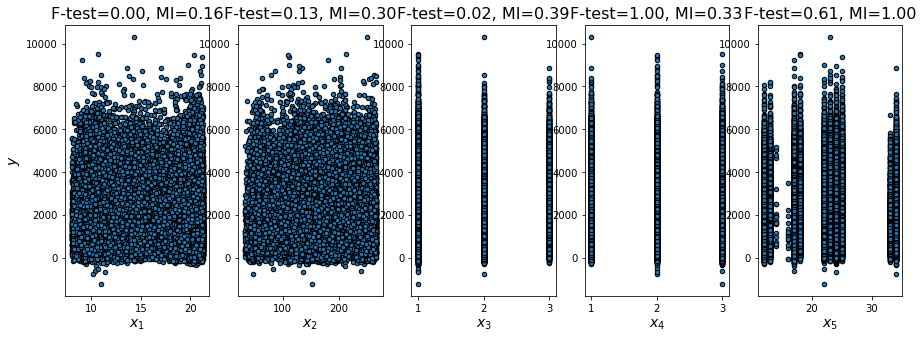

In [91]:
mi_cols = [  'item_w',  'item_mrp', 
       'out_size', 'out_type','outlet_age']

X = full_train[mi_cols]
y = train['sales']

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.scatter(X.iloc[:, i], y, edgecolor="black", s=20)
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]), fontsize=16)
plt.show()



In [92]:
list(zip(mi_cols, mi))

[('item_w', 0.16473068637653768),
 ('item_mrp', 0.2960984097944326),
 ('out_size', 0.39468828475425305),
 ('out_type', 0.3333055302969199),
 ('outlet_age', 1.0)]

### Scale numerical columns using Min-Max Normalization

In [93]:
for col in scale_cols:
    full_train[col+'_scale'] = (full_train[col] - min(full_train[col])) / (max(full_train[col]) - min(full_train[col]))
    x_test_id_split[col+'_scale'] = (x_test_id_split[col] - min(x_test_id_split[col])) / (max(x_test_id_split[col]) - min(x_test_id_split[col]))


In [94]:
x_test_id_split[scaled_cols].head()

,item_cat_0,item_cat_1,item_cat_2,item_cat_3,item_w_scale,item_type,item_mrp_scale,outlet_id,out_size,out_type,outlet_age_scale
0,D,R,M,23,0.334,Snack Foods,0.372,OUT013,3,1,0.455
1,F,D,G,47,0.350,Household,0.993,OUT018,3,1,1.000
2,F,D,N,21,0.442,Health and Hygiene,0.919,OUT018,3,3,0.545
3,F,D,Z,23,0.622,Dairy,0.444,OUT046,2,2,0.227
4,F,D,C,16,0.389,Canned,0.604,OUT018,2,1,0.000


### Create DictVectorizer instance for entire train set

In [95]:
full_dv = DictVectorizer()
full_train_dict = full_train[scaled_cols].to_dict(orient= 'records')
full_train_dv = full_dv.fit_transform(full_train_dict)

In [96]:
full_test_dict = x_test_id_split[scaled_cols].to_dict(orient= 'records')
full_test_dv = full_dv.transform(full_test_dict)

In [97]:
lr_full = LinearRegression()
lr_full.fit(full_train_dv, train['sales'])


lr_full_pred = lr_full.predict(full_train_dv)
mean_squared_error(train['sales'], lr_full_pred, squared=False)

1281.597055161418

In [98]:
dt_full = DecisionTreeRegressor(max_depth= 5, max_features=10, ccp_alpha=0.01 )
dt_full.fit(full_train_dv, train['sales'])
dt_full_pred = dt_full.predict(full_train_dv)
mean_squared_error(train['sales'], dt_full_pred, squared=False)

1287.1520440267245

### Display Decision Tree split as text

In [99]:
print(export_text(dt_full, feature_names=full_dv.get_feature_names()))

|--- item_type=Dairy <= 0.50
|   |--- item_type=Hard Drinks <= 0.50
|   |   |--- out_type <= 1.50
|   |   |   |--- item_cat_2=K <= 0.50
|   |   |   |   |--- item_type=Canned <= 0.50
|   |   |   |   |   |--- value: [1803.23]
|   |   |   |   |--- item_type=Canned >  0.50
|   |   |   |   |   |--- value: [1672.00]
|   |   |   |--- item_cat_2=K >  0.50
|   |   |   |   |--- item_type=Snack Foods <= 0.50
|   |   |   |   |   |--- value: [1721.64]
|   |   |   |   |--- item_type=Snack Foods >  0.50
|   |   |   |   |   |--- value: [1647.63]
|   |   |--- out_type >  1.50
|   |   |   |--- outlet_id=OUT046 <= 0.50
|   |   |   |   |--- item_type=Soft Drinks <= 0.50
|   |   |   |   |   |--- value: [1996.68]
|   |   |   |   |--- item_type=Soft Drinks >  0.50
|   |   |   |   |   |--- value: [2136.62]
|   |   |   |--- outlet_id=OUT046 >  0.50
|   |   |   |   |--- out_type <= 2.50
|   |   |   |   |   |--- value: [1930.41]
|   |   |   |   |--- out_type >  2.50
|   |   |   |   |   |--- value: [1880.12]
|   

In [100]:
dt_full_test_pred = dt_full.predict(test_dv_ext)
# export(dt_full_test_pred, 'dt_full')

In [101]:
full_train[col].head()

0    22
1    24
2    12
3    17
4    18
Name: outlet_age, dtype: int64

In [102]:
train['sales']

0         734.512
1        4146.958
2        2161.110
3        2267.133
4         581.665
           ...   
74679    1132.516
74680    2002.876
74681    1295.099
74682    1659.243
74683     884.406
Name: sales, Length: 74684, dtype: float64

In [103]:
rf_full = RandomForestRegressor(max_depth= 5, n_estimators= 50)
rf_full.fit(full_train_dv, train['sales'])
rf_full_pred = rf_full.predict(full_train_dv)
mean_squared_error(train['sales'], rf_full_pred, squared=False)

1276.1528351018699

### Parameter Tuning

Tuning takes time, hence below code block is commented. The best model is used to train data

In [104]:

# rf_tune = RandomForestRegressor()
# distrib = {
#     'n_estimators': [10, 50, 100, 150, 200],
#     'max_depth': [5, 10, 15, 20],
#     'max_features':['sqrt', 'log2', 5, 10, 15],
#     'ccp_alpha' : [0.01, 0.05, 0.1, .05],
#     'max_samples': [0.15, 0.25, 0.33, 0.5]
# }

# tuner = RandomizedSearchCV(rf_tune, distrib, random_state = 42)

# tuner.fit(full_train_dv, train['sales'])

In [105]:
# tuner.score

In [106]:
rf_tuned = RandomForestRegressor(ccp_alpha=0.05, max_depth=15, max_features=5,
                      max_samples=0.5, n_estimators=200)

rf_tuned.fit(full_train_dv, train['sales'])
rf_full_pred = rf_tuned.predict(full_train_dv)


In [107]:
rf_rmse= mean_squared_error( train['sales'], rf_full_pred, squared= False )
print(f'Tuned model RMSE: {round(rf_rmse, 3)}')

Tuned model RMSE: 1245.003


### XGBoost

Let's try boosting trees

Required Data objects:
- dv_ext
- train_dv_ext
- val_dv_ext
- test_dv_ext

#### Baseline XGB

In [130]:
features = dv_ext.get_feature_names()
dtrain = xgb.DMatrix(train_dv_ext, label= y_train, feature_names= features)
dval = xgb.DMatrix(val_dv_ext, label= y_val, feature_names= features)
dtest = xgb.DMatrix(full_test_dv, feature_names= features) 
dfulltrain = xgb.DMatrix(full_train_dv, label= train['sales'], feature_names= features) 

In [111]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [121]:
%%capture output
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_base = xgb.train(xgb_params, dtrain, num_boost_round=15, evals= watchlist)

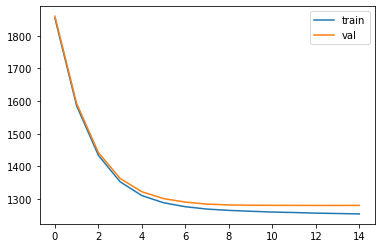

In [134]:
df_score = parse_xgb_output(output)

plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [113]:
xgb_train_pred = xgb_base.predict(dtrain)
xgb_val_pred = xgb_base.predict(dval)

In [118]:
xgb_train_score = mean_squared_error(y_train, xgb_train_pred, squared= False)
xgb_val_score = mean_squared_error(y_val, xgb_val_pred, squared= False)
print(f'XGB (train, val) RMSE: ({xgb_train_score}, {xgb_val_score})')

XGB (train, val) RMSE: (1262.3312881615866, 1280.794387402808)


#### Train baseline on full set

In [132]:
xgb_base_full = xgb.train(xgb_params, dfulltrain, num_boost_round=15)
xgb_base_full_pred = xgb_base_full.predict(dtest)
export(xgb_base_full_pred, 'xgb_base')

### Tuning XGB

##### Tuning `eta`

In [208]:
scores = {}

In [229]:
%%capture output

watchlist = [(dtrain, 'train'), (dval, 'val')]

# for eta in [0.01, 0.1, , 0.3, 0.5, 1]: #
tune_params = {
    'eta': 0.75, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(tune_params, dtrain, num_boost_round=200, evals=watchlist)
key = 'eta=%s' % (tune_params['eta'])
scores[key] = parse_xgb_output(output)
print(scores.keys())

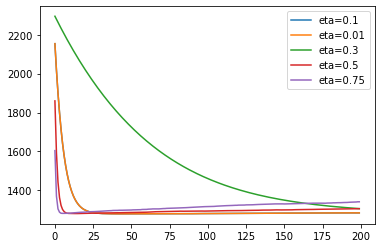

In [231]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)
plt.legend()

We will select `'eta': 0.3`

##### Tuning `max_depth`

In [252]:
scores = {}
watchlist = [(dtrain, 'train'), (dval, 'val')]


In [266]:
%%capture output

# for eta in [0.01, 0.1, , 0.3, 0.5, 1]: 
tune_params = {
    'eta':0.3, 
    'max_depth': 15,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(tune_params, dtrain, num_boost_round=200, evals=watchlist)
key = 'max_depth=%s' % (tune_params['max_depth'])
scores[key] = parse_xgb_output(output)


In [267]:
print(scores.keys())

dict_keys(['max_depth=3', 'max_depth=6', 'max_depth=10', 'max_depth=15'])


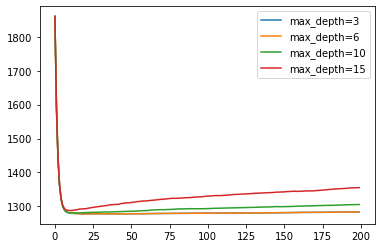

In [268]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=max_depth)
plt.legend()

We will select `'max_depth': 3`

##### Tuning 'min_child_weight'

In [269]:
scores = {}
watchlist = [(dtrain, 'train'), (dval, 'val')]


In [277]:
%%capture output

# for eta in [0.01, 0.1, , 0.3, 0.5, 1]: 
tune_params = {
    'eta':0.3, 
    'max_depth': 3,
    'min_child_weight': 200,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(tune_params, dtrain, num_boost_round=200, evals=watchlist)
key = 'min_child_weight=%s' % (tune_params['min_child_weight'])
scores[key] = parse_xgb_output(output)


In [279]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=25', 'min_child_weight=200'])

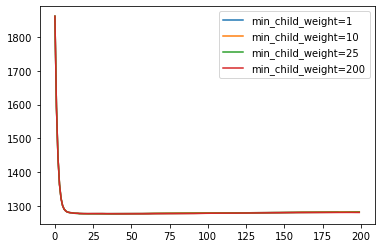

In [278]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=min_child_weight)
plt.legend()

We will select `'min_child_weight': 1`

##### Tuning `subsample`

In [295]:
scores = {}
watchlist = [(dtrain, 'train'), (dval, 'val')]


In [302]:
%%capture output

# for eta in [0.01, 0.1, , 0.3, 0.5, 1]: 
tune_params = {
    'eta':0.3, 
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(tune_params, dtrain, num_boost_round=50, evals=watchlist)
key = 'subsample=%s' % (tune_params['subsample'])
scores[key] = parse_xgb_output(output)


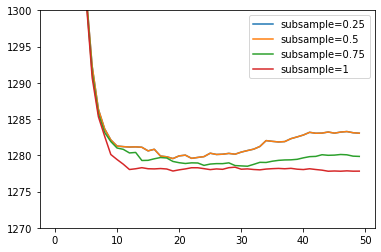

In [304]:
for subsample, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=subsample)
plt.ylim(1270, 1300)
plt.legend()

We will select `'subsample': 1`

##### Tuning `colsample_bytree`

In [317]:
scores = {}
watchlist = [(dtrain, 'train'), (dval, 'val')]


In [339]:
%%capture output

# for eta in [0.01, 0.1, , 0.3, 0.5, 1]: 
tune_params = {
    'eta':0.3, 
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 1,
    'sampling_method': 'gradient_based',
    'colsample_bytree': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(tune_params, dtrain, num_boost_round=100, evals=watchlist)
key = 'colsample_bytree=%s' % (tune_params['colsample_bytree'])
scores[key] = parse_xgb_output(output)


In [341]:
scores.keys()

dict_keys(['colsample_bytree=0.1', 'colsample_bytree=0.25', 'colsample_bytree=0.5', 'colsample_bytree=0.75', 'colsample_bytree=1'])

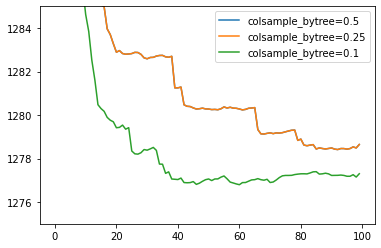

In [346]:
for colsample in ['colsample_bytree=0.5', 'colsample_bytree=0.25', 'colsample_bytree=0.1']:
#     colsample, df_score in scores.items():
    df_score = scores[colsample]
    plt.plot(df_score.num_iter, df_score.val_rmse, label=colsample)
plt.ylim(1275, 1285)
plt.legend()

In [ ]:
We will select 'colsample': 0.1


### Train tuned XGB on full train

In [305]:
tune_params = {
    'eta':0.3, 
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

In [307]:
xgb_tuned_full = xgb.train(tune_params, dfulltrain, num_boost_round=200)
xgb_tuned_full_pred = xgb_tuned_full.predict(dtest)
export(xgb_tuned_full_pred, 'xgb_tuned')

In [348]:
%%capture output

# for eta in [0.01, 0.1, , 0.3, 0.5, 1]: 
tune_params_ext = {
    'eta':0.3, 
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 1,
    'sampling_method': 'gradient_based',
    'colsample_bytree': 0.1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(tune_params, dtrain, num_boost_round=100, evals=watchlist)
key = 'colsample_bytree=%s' % (tune_params['colsample_bytree'])
scores[key] = parse_xgb_output(output)


In [350]:
xgb_tuned_full_ext = xgb.train(tune_params_ext, dfulltrain, num_boost_round=100)
xgb_tuned_full_pred_ext = xgb_tuned_full_ext.predict(dtest)
export(xgb_tuned_full_pred_ext, 'xgb_tuned_ext')

### Exporting to script
- We shall use the above model for making predictions. The training operations are exported to `train.py` script
<br>

- Further detailing is done in the [Wiki](https://github.com/ada-nai/ag-mlcamp/wiki/Store-Sales-Prediction#model-training)


### Making predictions on test set

In [ ]:
# rf_tuned_test_preds = rf_tuned.predict(full_test_dv)
# export(rf_tuned_test_preds, 'rf_tuned')

### Dump Objects

In [ ]:
# import pickle

# with open('model.bin', 'wb') as outfile:
#     pickle.dump(rf_tuned, outfile)
    
# with open('dv.bin', 'wb') as outfile:
#     pickle.dump(full_dv, outfile)
    
# with open('test_samples.bin', 'wb') as outfile:
#     pickle.dump(test_samples, outfile)

## Rough Work 

Below are some code snippets for quick prototyping of functions.  Code further on can be ignored

In [ ]:
test_samples= eval(df.sample(15, random_state= 42).to_json(orient= 'records'))
test_samples

In [ ]:
pd.DataFrame(test_samples).head()

In [ ]:
def retrieve_item_cats(df, col):
    """
    Split the item_id feature into categories
    """
    item_cats={}
    for x in range(4):
#         print(x)
        if x<3:
            item_cats[f'item_cat_{x}'] = [df[col][loc][x] for loc in range(len(df))]
        else:
            item_cats[f'item_cat_{x}'] = [df[col][loc][x:] for loc in range(len(df))]
    return item_cats

def scale_num_cols(df, scale_cols):
    for col in scale_cols:
        df[col+'_scale'] = (df[col] - min(df[col])) / (max(df[col]) - min(df[col]))
    return df

def process_data(df, cols):
    """

    """
    df = pd.DataFrame.from_dict(df).reset_index(drop= True)
    df_ids =  pd.DataFrame(retrieve_item_cats(df, 'item_id')).reset_index(drop= True)
    df_id_split = pd.concat([df, df_ids], axis= 1)
#     print([len(df), len(df_ids), len(df_id_split)])
    df_id_split['out_size'] = df['outlet_size'].map(outlet_size_map)
    df_id_split['out_type'] = df['outlet_location_type'].map(outlet_location_map)
    df_id_split['outlet_age']= 2021-df_id_split['outlet_year']
    df_id_split = scale_num_cols(df_id_split, scale_cols)

#     scale_num_cols(df_id_split, scale_cols)
    return df_id_split[scaled_cols]

In [ ]:
scale_cols = ['item_w', 'item_mrp', 'outlet_age']
scaled_cols = ['item_cat_0',
       'item_cat_1', 'item_cat_2', 'item_cat_3',  'item_w_scale', 'item_type', 'item_mrp_scale', 'outlet_id',
       'out_size', 'out_type','outlet_age_scale']
ip = process_data(test_samples, scaled_cols)

In [ ]:
# pd.DataFrame(test)
pd.DataFrame(test.values())